# RentSpree Test

In [144]:
# Library
import pandas as pd
import numpy as np
import calendar
import copy
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

### Setting

In [145]:
years = [2020, 2021]
months = list(calendar.month_name[1:])
churn = {'A': 360, 'B': 360, 'C': 120, 'D': 260}
max_date_range = '2021-04-30'
target_date_range = ['2020-04-1', max_date_range]

### Data Exploration

In [146]:
df = pd.read_csv('daily_transactions.csv', sep=',')
print(df.shape)
df.head(5)

(1210998, 3)


,_id,event_date,usertype
0,By1+rEy20nW/sgRehb+RSZe9VI8=,2021-02-10,A
1,x7lxSW+y6Kymzxf1yrriMXDNZWQ=,2021-02-10,A
2,BQ7feJAnc6ntg4PaOXShHLrd3xQ=,2021-02-24,A
3,xmc9CsW3Q7K9HK5+pczuRvKUCBk=,2020-12-08,A
4,Dt0y6YCKnC/mD9Sm1SkNkwsrgzY=,2020-06-17,A


In [147]:
# Convert column from obj to datetime
df['event_date'] = pd.to_datetime(df['event_date'])

# Sort dataframe
df = df[df['event_date'] <= max_date_range]
df = df.sort_values(by=['_id', 'event_date'])

### Check usertype
If the same user contain more than 1 types of class (A, B, C, D) then 
that users will not be including in the final result. The code
below check all uniques users if they contain more than 1 types of 
user class.

In [148]:
common_ids = list(df['_id'].unique())
groups = df.groupby(['_id'])

# Check type
def is_unique(data):
    check = data.to_numpy()
    return (check[0] == check).all()

for ids in tqdm(common_ids):
    group = groups.get_group(ids)

    if len(group) > 1:
        result = is_unique(group['usertype'])
        if result == False:
            df.drop(group.index)

100%|██████████| 432458/432458 [00:48<00:00, 9001.29it/s]


### Creating dictionary
The dictionary below are created to store the result of each type 
of user which are dropoff, returned or new users. The dictionary
created below will store the result from Jan 2020 to Dec 2021.

In [149]:
# Store result
newUser = {}

# Create dict to store new user
for y in years:
    for m in months:
        newUser["{}-{}".format(m, y)] = 0

# Copy
dropOff = copy.deepcopy(newUser)
returnUser = copy.deepcopy(newUser)

### Data Extraction
The total numbers of new users can be easily found by removing the duplicates of each ids
and keeping only the first row of each ids. Since we already sort the dataset before
removing the duplicates only the first ever transaction of each user is kept. Since this
is the first ever transaction we can automatically marked them as new users.

In [150]:
# Convert column from obj to datetime
df['event_date'] = pd.to_datetime(df['event_date'])

# Sort dataframe and drop duplicate
df_ft = df.drop_duplicates(subset=['_id'], keep='first')
df_ft = df_ft.sort_values(by='event_date')
df_ft['first_tran'] = True
df_ft_merge = df_ft

# Count new user for each months
for _, row in tqdm(df_ft.iterrows()):
    if row['event_date'].year in years:
        newUser["{}-{}".format(calendar.month_name[row['event_date'].month], row['event_date'].year)] += 1

# New users
newUser

432458it [00:20, 21235.88it/s]


{'January-2020': 12732,
 'February-2020': 12891,
 'March-2020': 13021,
 'April-2020': 15117,
 'May-2020': 20295,
 'June-2020': 22949,
 'July-2020': 30152,
 'August-2020': 28019,
 'September-2020': 21693,
 'October-2020': 22854,
 'November-2020': 18875,
 'December-2020': 19071,
 'January-2021': 23389,
 'February-2021': 22676,
 'March-2021': 31369,
 'April-2021': 34927,
 'May-2021': 0,
 'June-2021': 0,
 'July-2021': 0,
 'August-2021': 0,
 'September-2021': 0,
 'October-2021': 0,
 'November-2021': 0,
 'December-2021': 0}

This is the same as above since we can also keep the last ever transaction the users had ever done. 
We can added the churn periods of each type users and then count up when they would then be considered 
user that drop off the platform.

In [151]:
# Sort dataframe and drop duplicate
df_lt_churn = df.drop_duplicates(subset=['_id'], keep='last')
df_lt_churn = df_lt_churn.sort_values(by='event_date')
df_lt_merge = df_lt_churn

# Add the churn values to all of the row and count dropOff date
for idx, row in tqdm(df_lt_churn.iterrows()):
    diff = row['event_date'] + datetime.timedelta(days=churn[row['usertype']])
    
    if diff.year in years:
        dropOff["{}-{}".format(calendar.month_name[diff.month], diff.year)] += 1

# Old users
dropOff

432458it [00:29, 14474.13it/s]


{'January-2020': 861,
 'February-2020': 878,
 'March-2020': 820,
 'April-2020': 675,
 'May-2020': 7646,
 'June-2020': 10327,
 'July-2020': 11909,
 'August-2020': 10768,
 'September-2020': 9886,
 'October-2020': 9867,
 'November-2020': 9457,
 'December-2020': 9058,
 'January-2021': 12710,
 'February-2021': 12347,
 'March-2021': 12049,
 'April-2021': 15019,
 'May-2021': 20122,
 'June-2021': 21610,
 'July-2021': 29666,
 'August-2021': 28504,
 'September-2021': 20312,
 'October-2021': 21450,
 'November-2021': 18531,
 'December-2021': 18183}

Create a new dataframe that also contain labeling of each transaction 
whether it is the first transaction, last transaction or none of those.
This will contain all that transaction since the start of the given data set
till the max date that we had set at the start of the notebook.

In [152]:
# Add columns
df_lt_merge['last_tran'] = True

# Filter
df = df[df['event_date'] <= max_date_range]

# Merge
df_merge = pd.merge(df_ft_merge, df_lt_merge, how="outer", on=['_id', 'event_date', 'usertype'])
df_merge = pd.merge(df_merge, df, how="outer", on=['_id', 'event_date', 'usertype'])
df_merge = df_merge.replace(np.nan, False)

# Remove value with single transaction (true & true)
df_merge = df_merge[(df_merge['first_tran'] != True) | (df_merge['last_tran'] != True)]
df_merge

,_id,event_date,usertype,first_tran,last_tran
1,7mipoXGVQZq6/rW0j2aKY+AReDk=,2019-05-13,A,True,False
2,cmicF5fh0PE4a32wIERHoil1IdM=,2019-05-13,A,True,False
3,6kkeH6lJflikhoAIspU2LOwrJaE=,2019-05-13,B,True,False
6,0WD5EnMlD2TmXT/Fj2grzOi8i7w=,2019-05-13,A,True,False
7,Wu8ZeeM/pY6LFPBjHT61b/TwAWM=,2019-05-13,C,True,False
...,...,...,...,...,...
1200810,zzyMFNFuAwqAN1FMkTmCD7gs1fU=,2021-02-26,A,False,False
1200811,zzyMFNFuAwqAN1FMkTmCD7gs1fU=,2021-02-28,A,False,False
1200812,zzyMFNFuAwqAN1FMkTmCD7gs1fU=,2021-03-01,A,False,False
1200813,zzyMFNFuAwqAN1FMkTmCD7gs1fU=,2021-03-02,A,False,False


We can find the remained users by calculating the first transaction added the churn periods.
If the next transaction made by the same ids occurred before the added churn date then they
won't be counted as return user. However, if they return after the churn period then they are counted
as one. We also need to count drop off users in the process as they could come and leave. Once
they have been marked as returned we will calculate the new churn date as repeat the process.

In [153]:
all_ids = df_merge['_id'].unique()
groups = df_merge.groupby(['_id'])

# Check type
def count_returned(data):
    numpy_data = data.to_numpy()
    churn_period = numpy_data[0][1] + datetime.timedelta(days=churn[numpy_data[0][2]])
    
    for row in numpy_data:
        if row[1] > churn_period:
            if (row[1].year in years) and (churn_period.year in years):
                dropOff["{}-{}".format(calendar.month_name[churn_period.month], churn_period.year)] += 1
                returnUser["{}-{}".format(calendar.month_name[row[1].month], row[1].year)] += 1

            if row[4] != True:
                churn_period = row[1] + datetime.timedelta(days=churn[row[2]])
    
for ids in tqdm(all_ids):
    group = groups.get_group(ids)

    if len(group) > 1:
        count_returned(group)

returnUser

100%|██████████| 217738/217738 [00:44<00:00, 4904.78it/s]


{'January-2020': 41,
 'February-2020': 114,
 'March-2020': 151,
 'April-2020': 136,
 'May-2020': 740,
 'June-2020': 1013,
 'July-2020': 1156,
 'August-2020': 1149,
 'September-2020': 1039,
 'October-2020': 1175,
 'November-2020': 1046,
 'December-2020': 1223,
 'January-2021': 1664,
 'February-2021': 1759,
 'March-2021': 2460,
 'April-2021': 4901,
 'May-2021': 0,
 'June-2021': 0,
 'July-2021': 0,
 'August-2021': 0,
 'September-2021': 0,
 'October-2021': 0,
 'November-2021': 0,
 'December-2021': 0}

Generate the months between the target date and filter out the result of each
user count for the target date.

In [154]:
filter_range_start = datetime.datetime.strptime(target_date_range[0], '%Y-%m-%d')
filter_range_end = datetime.datetime.strptime(target_date_range[1], '%Y-%m-%d')
target_year = [filter_range_start.year, filter_range_end.year]
target_month = [filter_range_start.month, filter_range_end.month]

def get_month_list(year, month):
    target_month_list = []
    month_list = []

    # Store the first result
    target_month_list.append('{}-{}'.format(calendar.month_name[month[0]], year[0]))
    month_list.append('{} {}'.format(calendar.month_name[month[0]], year[0]))
    
    while (year[0], month[0]) <= (year[1], month[1] - 1):
        if month[0] == 12:
            month[0] = 1
            year[0] += 1
        else:
            month[0] += 1

        target_month_list.append('{}-{}'.format(calendar.month_name[month[0]], year[0]))
        month_list.append('{} {}'.format(calendar.month_name[month[0]], year[0]))
    
    return target_month_list, month_list

# Filter to the only desired target
def filter_result(data_range, result):
    store_keys = []
    for key in result:
        store_keys.append(key)

    for key in store_keys:
        if key not in data_range:
            del result[key]

# Filter result to intended month
filter_range, month_list = get_month_list(target_year, target_month)

filter_result(filter_range, returnUser)
filter_result(filter_range, dropOff)
filter_result(filter_range, newUser)

In [155]:
df_final = pd.DataFrame({'month': month_list, 'dropoff_users': pd.Series(dropOff), 'returning_user': pd.Series(returnUser), 'new_users': pd.Series(newUser)})
df_final

,month,dropoff_users,returning_user,new_users
April-2020,April 2020,1037,136,15117
May-2020,May 2020,11294,740,20295
June-2020,June 2020,12946,1013,22949
July-2020,July 2020,14110,1156,30152
August-2020,August 2020,12397,1149,28019
September-2020,September 2020,11268,1039,21693
October-2020,October 2020,11182,1175,22854
November-2020,November 2020,10495,1046,18875
December-2020,December 2020,10156,1223,19071
January-2021,January 2021,13951,1664,23389


In [156]:
# Store result to csv file
df_final.to_csv('result.csv', index=False)

## Visualisation

Text(0, 0.5, 'Users')

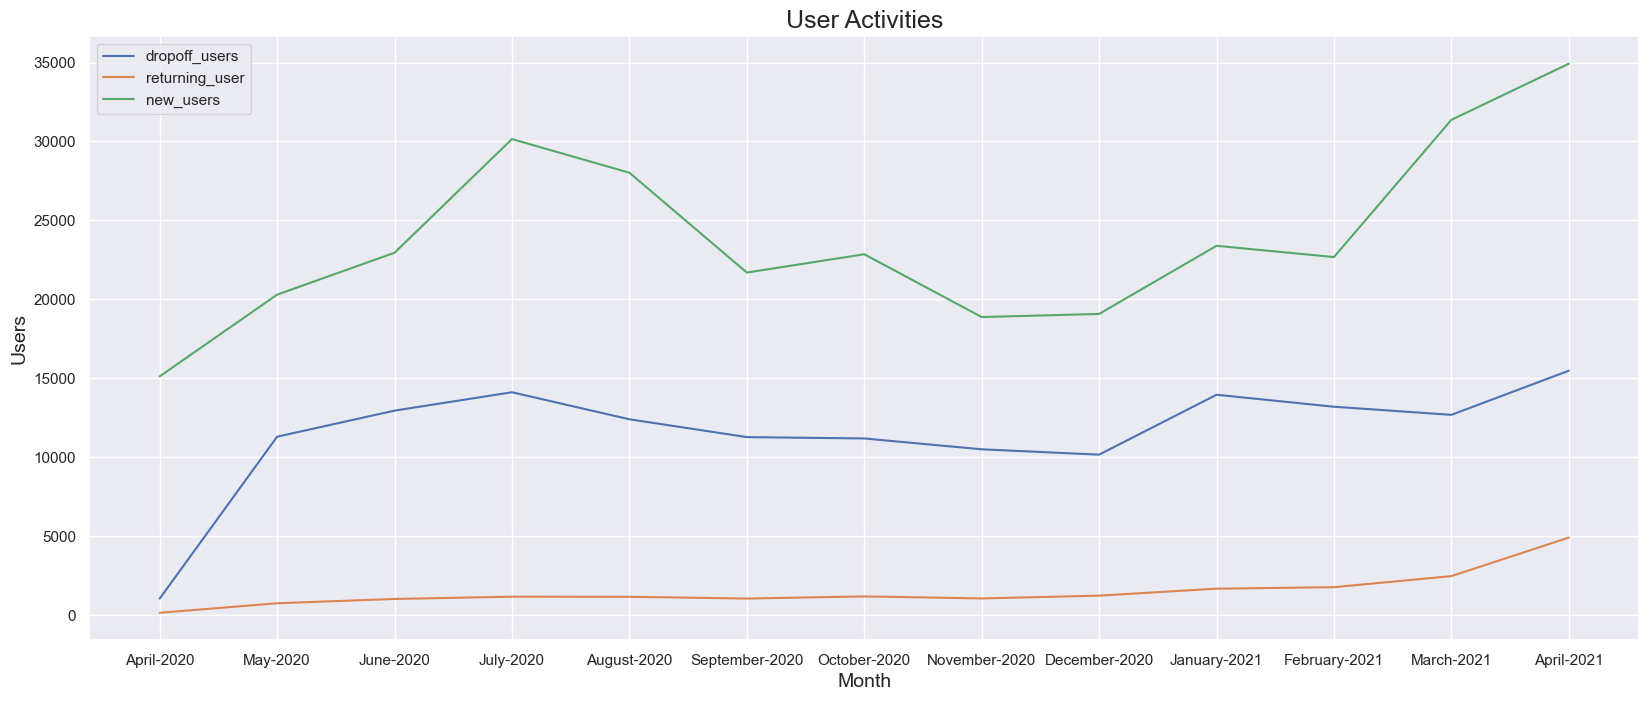

In [157]:
sns.set_theme(style='darkgrid')

plt.figure(figsize=(20, 8), dpi=100)
graph = sns.lineplot(data=df_final, dashes=False)
graph.set_title('User Activities', fontsize = 18)
graph.set_xlabel('Month', fontsize = 14)
graph.set_ylabel('Users', fontsize = 14)